In [1]:
import pydicom
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.model_selection import train_test_split

In [2]:
def load_dicom_image(path, img_size=256):
    # Load dicom and convert to 256x256 RGB image
    dicom = pydicom.dcmread(path)
    image = dicom.pixel_array
    image = Image.fromarray(image).convert('RGB')
    image = image.resize((img_size, img_size))
    return np.array(image) / 255.0

    # Convert to TensorFlow tensor
    return tf.convert_to_tensor(image, dtype=tf.float32)

In [17]:
def process_directory(directory_path, label, img_size=256):
    images, labels = [], []
    for root, dirs, files in os.walk(directory_path):
        for filename in files:
            # Check if the file is a DICOM file
            if filename.endswith('.dcm'):
                # Construct the full path to the DICOM file
                file_path = os.path.join(root, filename)
                # Load and process the image
                image = load_dicom_image(file_path, img_size=img_size)
                # Append the processed image and its label to the lists
                images.append(image)
                labels.append(label)
    return images, labels


In [18]:
# Adjusted handling for tensors when creating datasets
def create_datasets(cancer_dir, non_cancer_dir, img_size=256, batch_size=32, val_split=0.2):
    cancer_images, cancer_labels = process_directory(cancer_dir, 1, img_size=img_size)
    non_cancer_images, non_cancer_labels = process_directory(non_cancer_dir, 0, img_size=img_size)
    
    # Combine images and labels
    all_images = cancer_images + non_cancer_images
    all_labels = cancer_labels + non_cancer_labels
    
    # Convert labels to tensors
    all_labels = tf.convert_to_tensor(all_labels, dtype=tf.float32)
    
    # Create a dataset directly from tensors
    dataset = tf.data.Dataset.from_tensor_slices((all_images, all_labels))
    dataset = dataset.shuffle(buffer_size=len(all_images))
    
    # Split into training and validation datasets
    val_size = int(len(all_images) * val_split)
    val_dataset = dataset.take(val_size)
    train_dataset = dataset.skip(val_size)
    
    # Batch the datasets
    train_dataset = train_dataset.batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)
    
    return train_dataset, val_dataset

In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

def build_model_with_resnet(input_shape=(256, 256, 3), dropout_rate=0.5, l2_reg=0.001):
    base_model = ResNet50(input_shape=input_shape,
                          include_top=False,
                          weights='imagenet')
    base_model.trainable = False  

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [20]:
# train_dataset = create_dataset('/Users/arjunmoorthy/Desktop/Research_Capstone/Image Data/CapstoneData', img_size=256, batch_size=32)

train_dataset, val_dataset = create_datasets(
    cancer_dir='/Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/CapstoneData/cancer',
    non_cancer_dir='/Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/CapstoneData/non_cancer',
    img_size=256,  
    batch_size=32,  
    val_split=0.2   
)


In [21]:
def count_images_in_dataset(dataset):
    count = 0
    for images, _ in dataset:
        count += images.shape[0]  # Add the number of images in the batch
    return count

# Count the actual number of images
actual_train_images = count_images_in_dataset(train_dataset)
actual_val_images = count_images_in_dataset(val_dataset)

print(f"Actual number of images in training dataset: {actual_train_images}")
print(f"Actual number of images in validation dataset: {actual_val_images}")

2024-03-30 17:13:02.664550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Actual number of images in training dataset: 5088
Actual number of images in validation dataset: 1271


2024-03-30 17:13:03.459416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
model = build_model_with_resnet()

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Or another appropriate loss function
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

In [23]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset) 

Epoch 1/50


2024-03-30 17:13:20.900117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


159/159 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - accuracy: 0.5939 - auc: 0.5398 - loss: 0.7185 - precision: 0.4243 - recall: 0.2757 - val_accuracy: 0.7585 - val_auc: 0.6841 - val_loss: 0.5644 - val_precision: 1.0000 - val_recall: 0.3312
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7076 - auc: 0.6610 - loss: 0.5854 - precision: 0.7494 - recall: 0.3585 - val_accuracy: 0.7553 - val_auc: 0.6857 - val_loss: 0.5433 - val_precision: 1.0000 - val_recall: 0.3165
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7387 - auc: 0.6921 - loss: 0.5537 - precision: 0.9257 - recall: 0.3451 - val_accuracy: 0.7498 - val_auc: 0.6902 - val_loss: 0.5481 - val_precision: 1.0000 - val_recall: 0.3389
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7422 - auc: 0.6746 - loss: 0.5594 - precision: 0.9452 - recall: 0.3416 - val_accuracy: 0.7514 - val_auc: 0.6887 - val_loss: 0.5367 - val_precision: 1.0000 - val_recall: 0.3262
Epoch 5/50
159/159 ━━━━━━━━━━━━

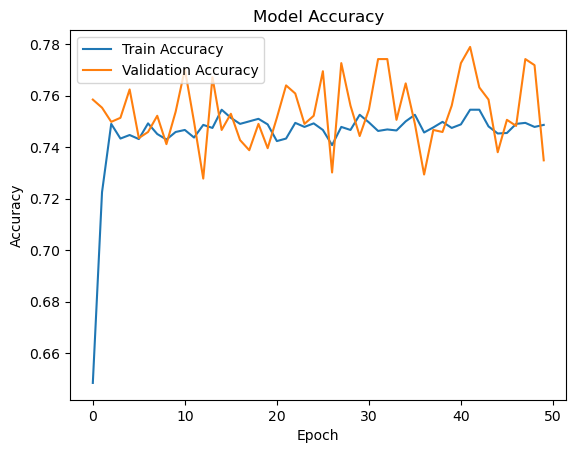

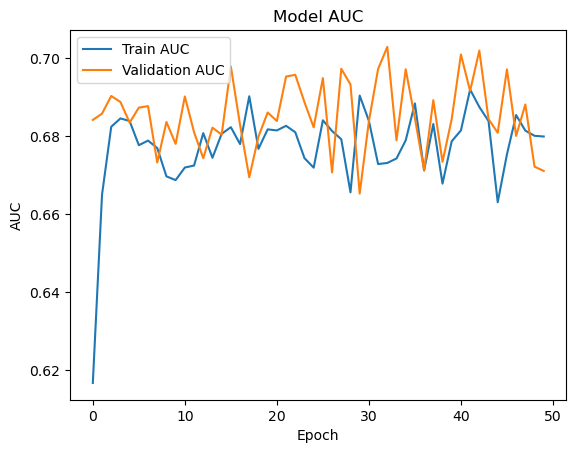

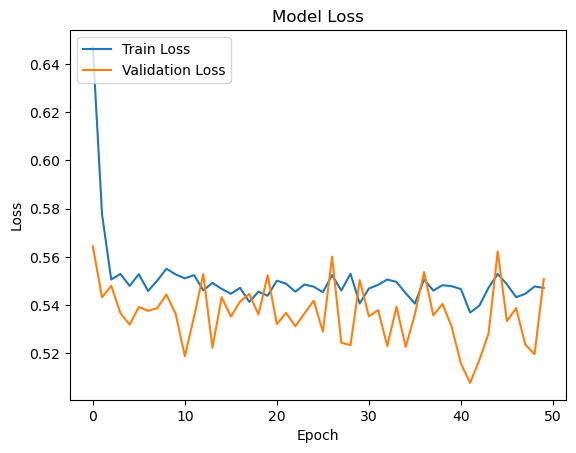

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation AUC values
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')  
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')  
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()